# RQ 1: rivers

What is the spatial extent of influence of the river contribution to surface waters in the CAA?
- Does the RCD span full straits in the CAA? If so, which and during all seasons or only for a portion of the year?
- How long does it take for river contributions in the central CAA to reach Baffin Bay?

Relative importance of rivers for trace metal cycles; general component comparison (how important are the rivers for Mn)

In [2]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from mpl_toolkits.basemap import Basemap, cm
import cmocean
import netCDF4 as nc
import os
from itertools import compress
import datetime as dt

%matplotlib notebook

In [3]:
import sys
sys.path.insert(0, '/ocean/brogalla/GEOTRACES/analysis-brogalla/modules')
import ariane as ar

##### Load domain dimensions for reference:

In [4]:
mask  = nc.Dataset('/ocean/brogalla/GEOTRACES/ariane_runs/ANHA12_Ariane_mesh.nc')
tmask = np.array(mask.variables['tmask'])
cond = (tmask[0,:,:,:] > 0.1) 
land_mask = np.ma.masked_where(cond, tmask[0,:,:,:]) 
tmask = tmask[0,:,1480:2050,160:800]

In [5]:
ref   = nc.Dataset('/data/brogalla/run_storage/reference/ANHA12_EXH006_2002_monthly.nc',  'r')
tlons = np.array(ref.variables['nav_lon'])
tlats = np.array(ref.variables['nav_lat'])
lons  = np.array(ref.variables['nav_lon'])[1480:2050,160:800]
lats  = np.array(ref.variables['nav_lat'])[1480:2050,160:800]
depth = np.array(ref.variables['deptht'])

In [6]:
# Load structure from sample dataset:
lat_model = ref.variables['nav_lat']
lon_model = ref.variables['nav_lon']
depths_model = ref.variables['deptht']
lat_model = np.array(lat_model)
lon_model = np.array(lon_model)
depths_model = np.array(depths_model)

### Load Mn model run results:

In [7]:
def load_results(folder_ref, folder_riv, folder_sed, folder_atm, folder_ice, folder_scav):
    
    file   = 'ANHA12_EXH006_2002_monthly.nc'
    ref_monthly  = nc.Dataset(folder_ref+file)
    riv_monthly  = nc.Dataset(folder_riv+file)
    sed_monthly  = nc.Dataset(folder_sed+file)
#     bio_monthly  = nc.Dataset(folder_bio+file)
    atm_monthly  = nc.Dataset(folder_atm+file)
    ice_monthly  = nc.Dataset(folder_ice+file)
    scav_monthly = nc.Dataset(folder_scav+file)
    
    dmn_ref_monthly  = np.array(ref_monthly.variables['dissolmn'])[:,0,:,:,:]
    dmn_riv_monthly  = np.array(riv_monthly.variables['dissolmn'])[:,0,:,:,:]
    dmn_sed_monthly  = np.array(sed_monthly.variables['dissolmn'])[:,0,:,:,:]
#     dmn_bio_monthly  = np.array(bio_monthly.variables['dissolmn'])[:,0,:,:,:]
    dmn_atm_monthly  = np.array(atm_monthly.variables['dissolmn'])[:,0,:,:,:]
    dmn_ice_monthly  = np.array(ice_monthly.variables['dissolmn'])[:,0,:,:,:]
    dmn_scav_monthly = np.array(scav_monthly.variables['dissolmn'])[:,0,:,:,:]
    
    tmask_full    = np.empty(dmn_ref_monthly.shape)
    tmask_full[:] = tmask
    
    dmn_mref  = np.ma.masked_where((tmask_full < 0.1), dmn_ref_monthly)
    dmn_mriv  = np.ma.masked_where((tmask_full < 0.1), dmn_riv_monthly)
    dmn_msed  = np.ma.masked_where((tmask_full < 0.1), dmn_sed_monthly)
#     dmn_mbio  = np.ma.masked_where((tmask_full < 0.1), dmn_bio_monthly)
    dmn_matm  = np.ma.masked_where((tmask_full < 0.1), dmn_atm_monthly)
    dmn_mice  = np.ma.masked_where((tmask_full < 0.1), dmn_ice_monthly)
    dmn_mscav = np.ma.masked_where((tmask_full < 0.1), dmn_scav_monthly)

    return dmn_mref, dmn_mriv, dmn_msed, dmn_matm, dmn_mice, dmn_mscav

In [8]:
folder_ref  = '/data/brogalla/run_storage/reference/'
folder_riv  = '/data/brogalla/run_storage/comp-riv-off/'
folder_sed  = '/data/brogalla/run_storage/comp-sed-off/'
folder_atm  = '/data/brogalla/run_storage/comp-atm-off/'
folder_ice  = '/data/brogalla/run_storage/comp-ice-off/'
folder_scav = '/data/brogalla/run_storage/comp-sca-off/'

In [9]:
dmn_mref, dmn_mriv, dmn_msed, dmn_matm, dmn_mice, dmn_mscav = \
        load_results(folder_ref, folder_riv, folder_sed, folder_atm, folder_ice, folder_scav)

Calculate the proportional contribution of each component to each grid cell:

In [10]:
def calculate_prop(dmn_on, dmn_off):
    # Input arguments:
    # - dmn_on (t,z,y,x) --- concentration of dMn with component on
    # - dmn_off(t,z,y,x) --- concentration of dMn with component off
    
    # Contribution of component at each point
    diff = dmn_on - dmn_off
#     diff[diff < 0] = 0
    
    # Contribution of rivers / total concentration (with rivers on):
    # should be an elementwise operation
    prop  = np.divide(np.abs(diff), dmn_on)
#     prop  = np.divide(diff, dmn_on)
    
    # Output:
    # - prop(t,z,y,x)  --- proportional contribution of component to simulated [dMn]
    return prop

In [11]:
def all_props(ref, riv, sed, atm, ice, scav):
    
    riv_prop  = calculate_prop(ref, riv)
    sed_prop  = calculate_prop(ref, sed)
#     bio_prop  = calculate_prop(ref, bio)
    atm_prop  = calculate_prop(ref, atm)
    ice_prop  = calculate_prop(ref, ice)
    scav_prop = calculate_prop(ref, scav)
    
    return riv_prop, sed_prop, atm_prop, ice_prop, scav_prop

In [12]:
riv_prop, sed_prop, atm_prop, ice_prop, scav_prop = \
    all_props(dmn_mref, dmn_mriv, dmn_msed, dmn_matm, dmn_mice, dmn_mscav)

/home/brogalla/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in true_divide
  if sys.path[0] == '':
/home/brogalla/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in true_divide
  if sys.path[0] == '':


In [13]:
width = 0.5

colors = ['#ccb598', '#007378', '#739f78', '#cc7722', '#cee7fd'] # dust, rivers, scavenging, sediment diffusion

months = ['Jan','Feb', 'Mar', 'Apr', 'May', 'June', 'July', 'Aug', 'Sept', 'Oct', 'Nov', 'Dec']

### Bar plots

In [25]:
riv_prop.shape

(12, 50, 570, 640)

In [24]:
dust_ave   = np.average(atm_prop,axis=(1,2,3))
rivers_ave = np.average(riv_prop,axis=(1,2,3))
scav_ave   = np.average(scav_prop,axis=(1,2,3))
sed_ave    = np.average(sed_prop,axis=(1,2,3))
ice_ave    = np.average(ice_prop,axis=(1,2,3))

total = dust_ave + rivers_ave + scav_ave + sed_ave + ice_ave

dust_sum_ave   = dust_ave*100/total
rivers_sum_ave = rivers_ave*100/total
scav_sum_ave   = scav_ave*100/total
sed_sum_ave    = sed_ave*100/total
ice_sum_ave    = ice_ave*100/total

<IPython.core.display.Javascript object>


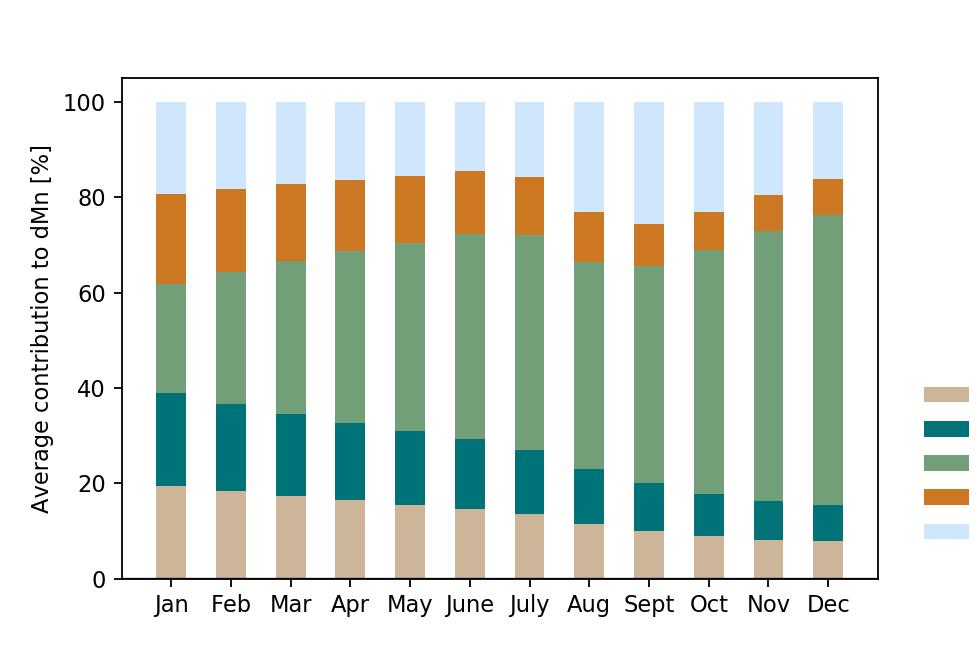

Text(0, 0.5, 'Average contribution to dMn [%]')

In [17]:
fig, ax = plt.subplots(figsize=(6,4))

for i in range(0,12):
    ax.bar(months[i], dust_sum_ave[i], width, color=colors[0])
    ax.bar(months[i], rivers_sum_ave[i], width, bottom=dust_sum_ave[i], color=colors[1])
    ax.bar(months[i], scav_sum_ave[i], width, bottom=np.add(dust_sum_ave[i],rivers_sum_ave[i]), color=colors[2])
    ax.bar(months[i], sed_sum_ave[i], width, bottom=np.add(np.add(dust_sum_ave[i], rivers_sum_ave[i]),scav_sum_ave[i]), color=colors[3])
    ax.bar(months[i], ice_sum_ave[i], width, bottom=np.add(np.add(np.add(dust_sum_ave[i], rivers_sum_ave[i]), \
                                                           scav_sum_ave[i]),sed_sum_ave[i]), color=colors[4])
# for legend:
ax.bar(months[0], dust_sum_ave[0]  , 0, color=colors[0], label='Dust')
ax.bar(months[0], rivers_sum_ave[0], 0, color=colors[1], label='Rivers')
ax.bar(months[0], scav_sum_ave[0]  , 0, color=colors[2], label='Scavenging')
ax.bar(months[0], sed_sum_ave[0]   , 0, color=colors[3], label='Sediment resuspension')
ax.bar(months[0], ice_sum_ave[0]   , 0, color=colors[4], label='Ice')
ax.legend(loc=(1.05,0.05), frameon=False)
    
xmin, xmax = ax.get_xlim()
ax.set_xlim([xmin, xmax])
ax.plot([xmin, xmax],[0, 0],'-k',linewidth=1)
# ax.ticklabel_format(axis='y',scilimits=(-1, 1))
ax.set_ylabel('Average contribution to dMn [%]')

# fig.savefig('/ocean/brogalla/GEOTRACES/figures/Mn-components.png', bbox_inches='tight')

### Overview of component contributions within water masses: 

- Polar mixed layer (0-40 m)
    - PML depth levels = 1 to 17
- Pacific/halocline water (40-300 m)
    - PW depth levels = 17 to 29
- Atlantic water (300-800 m)
    - AW depth levels = 29 to 35
- Deep water (> 800 m)
    - DW depth levels = 35-50
    
Note that if a component has a negative contribution (i.e. removal), I take the absolute value of this contribution. So, what I'm really looking at is the importance of the component in the concentration/distribution of the trace metal.

In [71]:
PML_dust_ave   = np.average(atm_prop[:,0:17,:,:],axis=(1,2,3))
PML_rivers_ave = np.average(riv_prop[:,0:17,:,:],axis=(1,2,3))
PML_scav_ave   = np.average(scav_prop[:,0:17,:,:],axis=(1,2,3))
PML_sed_ave    = np.average(sed_prop[:,0:17,:,:],axis=(1,2,3))
PML_ice_ave    = np.average(ice_prop[:,0:17,:,:],axis=(1,2,3))

PML_total = PML_dust_ave + PML_rivers_ave + PML_scav_ave + PML_sed_ave + PML_ice_ave

PML_dust_sum_ave   = PML_dust_ave*100/PML_total
PML_rivers_sum_ave = PML_rivers_ave*100/PML_total
PML_scav_sum_ave   = PML_scav_ave*100/PML_total
PML_sed_sum_ave    = PML_sed_ave*100/PML_total
PML_ice_sum_ave    = PML_ice_ave*100/PML_total

In [72]:
PW_dust_ave   = np.average(atm_prop[:,17:29,:,:],axis=(1,2,3))
PW_rivers_ave = np.average(riv_prop[:,17:29,:,:],axis=(1,2,3))
PW_scav_ave   = np.average(scav_prop[:,17:29,:,:],axis=(1,2,3))
PW_sed_ave    = np.average(sed_prop[:,17:29,:,:],axis=(1,2,3))
PW_ice_ave    = np.average(ice_prop[:,17:29,:,:],axis=(1,2,3))

PW_total = PW_dust_ave + PW_rivers_ave + PW_scav_ave + PW_sed_ave + PW_ice_ave

PW_dust_sum_ave   = PW_dust_ave*100/PW_total
PW_rivers_sum_ave = PW_rivers_ave*100/PW_total
PW_scav_sum_ave   = PW_scav_ave*100/PW_total
PW_sed_sum_ave    = PW_sed_ave*100/PW_total
PW_ice_sum_ave    = PW_ice_ave*100/PW_total

In [73]:
AW_dust_ave   = np.average(atm_prop[:,29:35,:,:],axis=(1,2,3))
AW_rivers_ave = np.average(riv_prop[:,29:35,:,:],axis=(1,2,3))
AW_scav_ave   = np.average(scav_prop[:,29:35,:,:],axis=(1,2,3))
AW_sed_ave    = np.average(sed_prop[:,29:35,:,:],axis=(1,2,3))
AW_ice_ave    = np.average(ice_prop[:,29:35,:,:],axis=(1,2,3))

AW_total = AW_dust_ave + AW_rivers_ave + AW_scav_ave + AW_sed_ave + AW_ice_ave

AW_dust_sum_ave   = AW_dust_ave*100/AW_total
AW_rivers_sum_ave = AW_rivers_ave*100/AW_total
AW_scav_sum_ave   = AW_scav_ave*100/AW_total
AW_sed_sum_ave    = AW_sed_ave*100/AW_total
AW_ice_sum_ave    = AW_ice_ave*100/AW_total

In [74]:
DW_dust_ave   = np.average(atm_prop[:,35:50,:,:],axis=(1,2,3))
DW_rivers_ave = np.average(riv_prop[:,35:50,:,:],axis=(1,2,3))
DW_scav_ave   = np.average(scav_prop[:,35:50,:,:],axis=(1,2,3))
DW_sed_ave    = np.average(sed_prop[:,35:50,:,:],axis=(1,2,3))
DW_ice_ave    = np.average(ice_prop[:,35:50,:,:],axis=(1,2,3))

DW_total = DW_dust_ave + DW_rivers_ave + DW_scav_ave + DW_sed_ave + DW_ice_ave

DW_dust_sum_ave   = DW_dust_ave*100/DW_total
DW_rivers_sum_ave = DW_rivers_ave*100/DW_total
DW_scav_sum_ave   = DW_scav_ave*100/DW_total
DW_sed_sum_ave    = DW_sed_ave*100/DW_total
DW_ice_sum_ave    = DW_ice_ave*100/DW_total

In [78]:
def proportions_bar(fig, ax, ice_sum_ave, dust_sum_ave, rivers_sum_ave, scav_sum_ave, sed_sum_ave, name, legend=False):
    for i in range(0,12):
        ax.bar(months[i], dust_sum_ave[i], width, color=colors[0])
        ax.bar(months[i], rivers_sum_ave[i], width, bottom=dust_sum_ave[i], color=colors[1])
        ax.bar(months[i], scav_sum_ave[i], width, bottom=np.add(dust_sum_ave[i],rivers_sum_ave[i]), color=colors[2])
        ax.bar(months[i], sed_sum_ave[i], width, bottom=np.add(np.add(dust_sum_ave[i], rivers_sum_ave[i]),scav_sum_ave[i]), color=colors[3])
        ax.bar(months[i], ice_sum_ave[i], width, bottom=np.add(np.add(np.add(dust_sum_ave[i], rivers_sum_ave[i]), \
                                                               scav_sum_ave[i]),sed_sum_ave[i]), color=colors[4])

    ax.set_title(name, fontsize=14)
    # for legend:
    if legend:
        ax.bar(months[0], dust_sum_ave[0]  , 0, color=colors[0], label='Dust')
        ax.bar(months[0], rivers_sum_ave[0], 0, color=colors[1], label='Rivers')
        ax.bar(months[0], scav_sum_ave[0]  , 0, color=colors[2], label='Scavenging')
        ax.bar(months[0], sed_sum_ave[0]   , 0, color=colors[3], label='Sediment resuspension')
        ax.bar(months[0], ice_sum_ave[0]   , 0, color=colors[4], label='Ice')
        ax.legend(loc=(1.05, 0.05), frameon=False)
    return

<IPython.core.display.Javascript object>


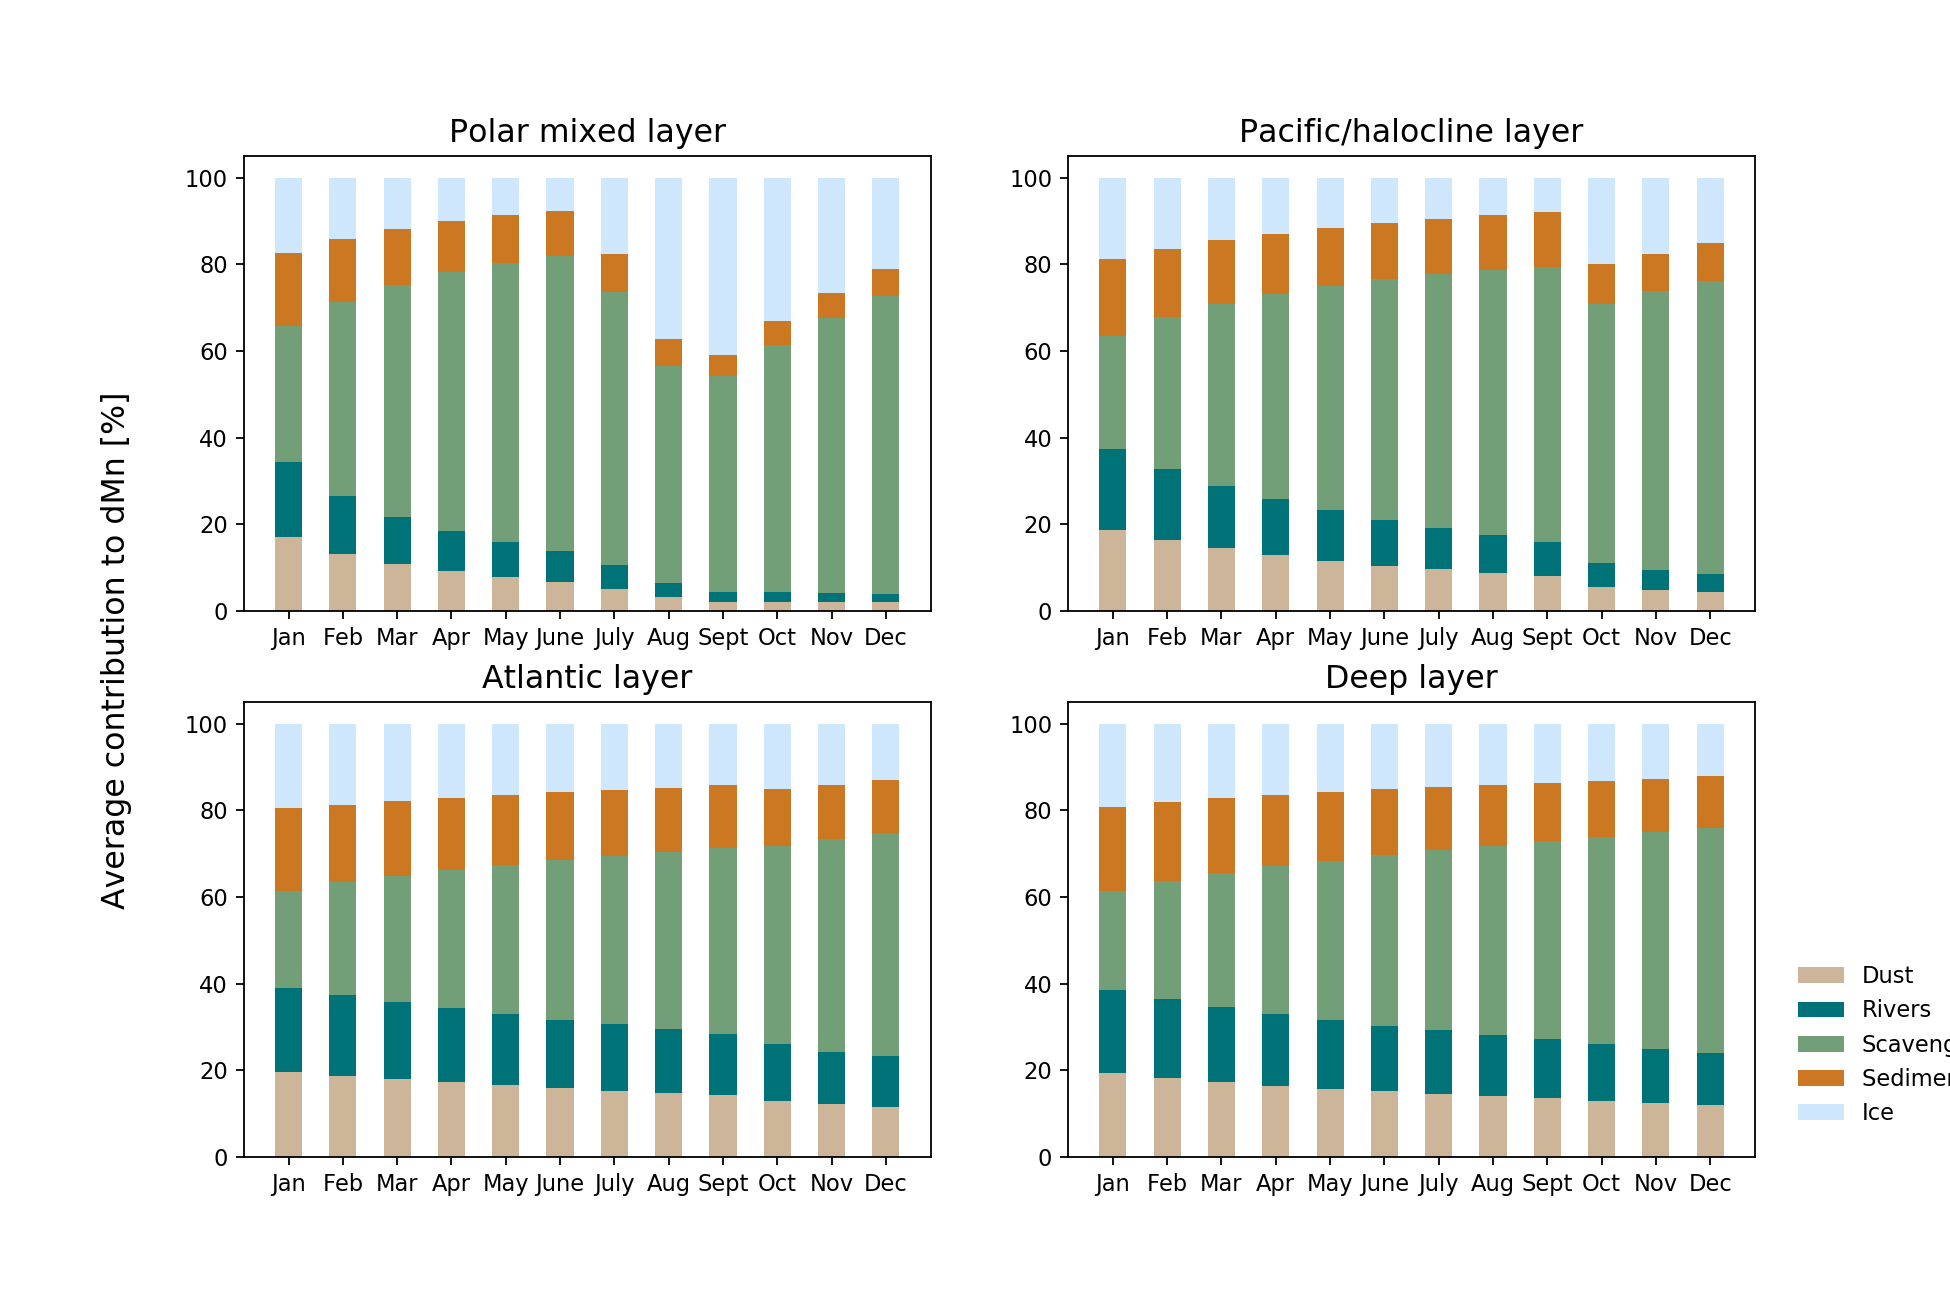

In [80]:
fig, ax = plt.subplots(2,2, figsize=(12,8))

proportions_bar(fig, ax[0,0], PML_ice_sum_ave, PML_dust_sum_ave, PML_rivers_sum_ave, \
                PML_scav_sum_ave, PML_sed_sum_ave, 'Polar mixed layer')
proportions_bar(fig, ax[0,1], PW_ice_sum_ave, PW_dust_sum_ave, PW_rivers_sum_ave, \
                PW_scav_sum_ave, PW_sed_sum_ave, 'Pacific/halocline layer')
proportions_bar(fig, ax[1,0], AW_ice_sum_ave, AW_dust_sum_ave, AW_rivers_sum_ave, \
                AW_scav_sum_ave, AW_sed_sum_ave, 'Atlantic layer')
proportions_bar(fig, ax[1,1], DW_ice_sum_ave, DW_dust_sum_ave, DW_rivers_sum_ave, \
                DW_scav_sum_ave, DW_sed_sum_ave, 'Deep layer', legend=True)

fig.text(0.06, 0.5, 'Average contribution to dMn [%]', \
         ha='center', va='center', rotation='vertical', fontsize=14);

fig.savefig('/ocean/brogalla/GEOTRACES/figures/Mn-components-layers.png', bbox_inches='tight')

## Map of surface with the most important component

In [14]:
def comp_importance(month, zlevel, riv_prop=riv_prop, sed_prop=sed_prop, atm_prop=atm_prop, ice_prop=ice_prop, \
                   scav_prop=scav_prop, output=False):
    
    riv_imp = np.ma.masked_where((riv_prop[month,z_level,:,:] < sed_prop[month,z_level,:,:]), \
                             riv_prop[month,z_level,:,:])
    riv_imp = np.ma.masked_where((riv_imp[:,:]  < atm_prop[month,z_level,:,:]), riv_imp[:,:])
    riv_imp = np.ma.masked_where((riv_imp[:,:]  < ice_prop[month,z_level,:,:]), riv_imp[:,:])
    riv_imp = np.ma.masked_where((riv_imp[:,:]  < scav_prop[month,z_level,:,:]), riv_imp[:,:])

    sed_imp = np.ma.masked_where((sed_prop[month,z_level,:,:] < riv_prop[month,z_level,:,:]), \
                                 sed_prop[month,z_level,:,:])
    sed_imp = np.ma.masked_where((sed_imp[:,:]  < atm_prop[month,z_level,:,:]), sed_imp[:,:])
    sed_imp = np.ma.masked_where((sed_imp[:,:]  < ice_prop[month,z_level,:,:]), sed_imp[:,:])
    sed_imp = np.ma.masked_where((sed_imp[:,:]  < scav_prop[month,z_level,:,:]), sed_imp[:,:])


    sca_imp = np.ma.masked_where((scav_prop[month,z_level,:,:] < sed_prop[month,z_level,:,:]), \
                                 scav_prop[month,z_level,:,:])
    sca_imp = np.ma.masked_where((sca_imp[:,:]  < atm_prop[month,z_level,:,:]), sca_imp[:,:])
    sca_imp = np.ma.masked_where((sca_imp[:,:]  < ice_prop[month,z_level,:,:]), sca_imp[:,:])
    sca_imp = np.ma.masked_where((sca_imp[:,:]  < riv_prop[month,z_level,:,:]), sca_imp[:,:])

    ice_imp = np.ma.masked_where((ice_prop[month,z_level,:,:] < sed_prop[month,z_level,:,:]), \
                                 ice_prop[month,z_level,:,:])
    ice_imp = np.ma.masked_where((ice_imp[:,:]  < atm_prop[month,z_level,:,:]), ice_imp[:,:])
    ice_imp = np.ma.masked_where((ice_imp[:,:]  < riv_prop[month,z_level,:,:]), ice_imp[:,:])
    ice_imp = np.ma.masked_where((ice_imp[:,:]  < scav_prop[month,z_level,:,:]), ice_imp[:,:])

    atm_imp = np.ma.masked_where((atm_prop[month,z_level,:,:] < sed_prop[month,z_level,:,:]), \
                                 atm_prop[month,z_level,:,:])
    atm_imp = np.ma.masked_where((atm_imp[:,:]  < riv_prop[month,z_level,:,:]), atm_imp[:,:])
    atm_imp = np.ma.masked_where((atm_imp[:,:]  < ice_prop[month,z_level,:,:]), atm_imp[:,:])
    atm_imp = np.ma.masked_where((atm_imp[:,:]  < scav_prop[month,z_level,:,:]), atm_imp[:,:])

    if output:
        print('Rivers     --- Masked values before: ', np.ma.count_masked(riv_prop[month,z_level,:,:]), ', after: ', \
          np.ma.count_masked(riv_imp[:,:]))
        print('Rivers     --- Non-masked values:    ',np.ma.count(riv_imp[:,:]))
        print('Sediment   --- Masked values before: ', np.ma.count_masked(sed_prop[month,z_level,:,:]), ', after: ', \
          np.ma.count_masked(sed_imp[:,:]))
        print('Sediment   --- Non-masked values:    ',np.ma.count(sed_imp[:,:]))
        print('Scavenging --- Masked values before: ', np.ma.count_masked(scav_prop[month,z_level,:,:]), ', after: ', \
          np.ma.count_masked(sca_imp[:,:]))
        print('Scavenging --- Non-masked values:    ',np.ma.count(sca_imp[:,:]))
        print('Ice        --- Masked values before: ', np.ma.count_masked(ice_prop[month,z_level,:,:]), ', after: ', \
          np.ma.count_masked(ice_imp[:,:]))
        print('Ice        --- Non-masked values:    ',np.ma.count(ice_imp[:,:]))
        print('Dust       --- Masked values before: ', np.ma.count_masked(atm_prop[month,z_level,:,:]), ', after: ', \
          np.ma.count_masked(atm_imp[:,:]))
        print('Dust       --- Non-masked values:    ',np.ma.count(atm_imp[:,:]))

    return riv_imp, sed_imp, sca_imp, ice_imp, atm_imp

In [15]:
month   = 8
z_level = 0

In [16]:
riv_imp, sed_imp, sca_imp, ice_imp, atm_imp = comp_importance(month, z_level, output=True)

Rivers     --- Masked values before:  182461 , after:  363597
Rivers     --- Non-masked values:     1203
Sediment   --- Masked values before:  182461 , after:  363644
Sediment   --- Non-masked values:     1156
Scavenging --- Masked values before:  182461 , after:  294953
Scavenging --- Non-masked values:     69847
Ice        --- Masked values before:  182461 , after:  251490
Ice        --- Non-masked values:     113310
Dust       --- Masked values before:  182461 , after:  363741
Dust       --- Non-masked values:     1059


### If we only count the sources of dMn (so no removal by scavenging):

<IPython.core.display.Javascript object>


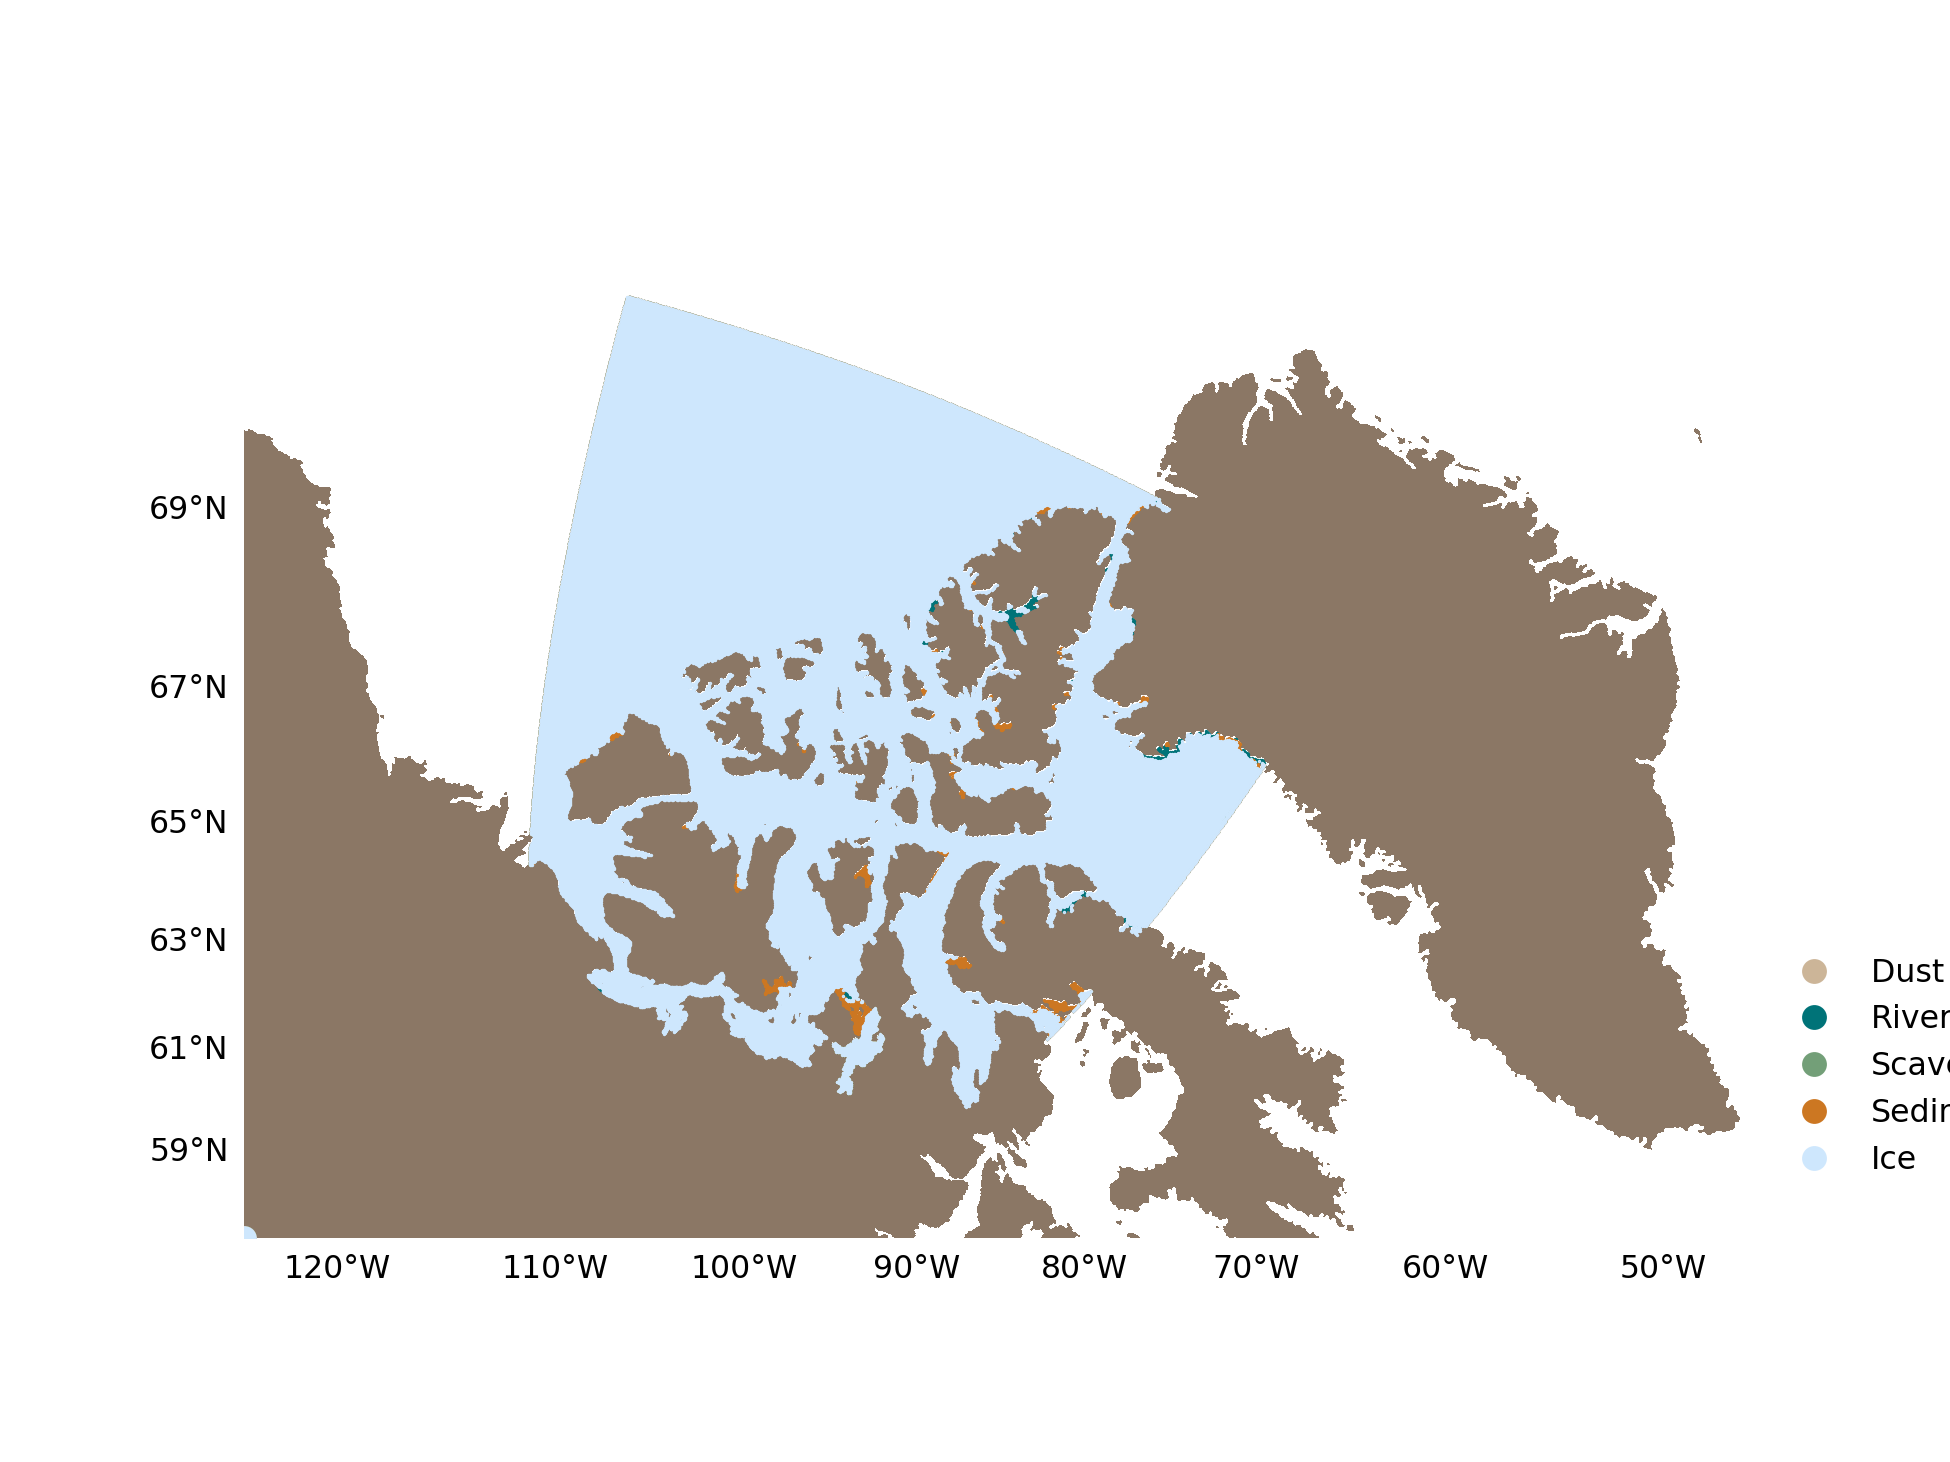

In [30]:
fig, ax1, proj1 = pickle.load(open('/ocean/brogalla/GEOTRACES/analysis-brogalla/maps/mn-reference.pickle','rb'))
#-----------------------------------------------------------------------------
x, y = proj1(lon_model, lat_model)
proj1.plot(x[~atm_imp.mask], y[~atm_imp.mask],'.', markersize=1,c=colors[0])
proj1.plot(x[~riv_imp.mask], y[~riv_imp.mask],'.', markersize=1, c=colors[1])
proj1.plot(x[~sca_imp.mask], y[~sca_imp.mask],'.', markersize=1, c=colors[2])
proj1.plot(x[~sed_imp.mask], y[~sed_imp.mask],'.', markersize=1, c=colors[3])
proj1.plot(x[~ice_imp.mask], y[~ice_imp.mask],'.', markersize=1, c=colors[4])

proj1.plot(0,0,'.', markersize=20,c=colors[0], label='Dust from atmosphere')
proj1.plot(0,0,'.', markersize=20, c=colors[1], label='River')
proj1.plot(0,0,'.', markersize=20, c=colors[2], label='Scavenging')
proj1.plot(0,0,'.', markersize=20, c=colors[3], label='Sediment')
proj1.plot(0,0,'.', markersize=20, c=colors[4], label='Ice')

ax1.legend(loc=(1.01, 0.05), fontsize=14, frameon=False)

# fig.savefig('/ocean/brogalla/GEOTRACES/figures/comp_only-sources.png', bbox_inches='tight')

### Seasonal cycle:

In [19]:
def plot_year_importance(z_level, fig, ax, proj1):
    
    x, y = proj1(lon_model, lat_model)
    
    axes=[ax[0,0], ax[0,1], ax[0,2], ax[0,3], \
          ax[1,0], ax[1,1], ax[1,2], ax[1,3], \
          ax[2,0], ax[2,1], ax[2,2], ax[2,3]]
    
    for month in range(0,12):
        riv_imp, sed_imp, sca_imp, ice_imp, atm_imp = comp_importance(month, z_level)
    
        proj1.plot(x[~atm_imp.mask], y[~atm_imp.mask],'.', markersize=1,c=colors[0], ax=axes[month])
        proj1.plot(x[~riv_imp.mask], y[~riv_imp.mask],'.', markersize=1, c=colors[1], ax=axes[month])
        proj1.plot(x[~sca_imp.mask], y[~sca_imp.mask],'.', markersize=1, c=colors[2], ax=axes[month])
        proj1.plot(x[~sed_imp.mask], y[~sed_imp.mask],'.', markersize=1, c=colors[3], ax=axes[month])
        proj1.plot(x[~ice_imp.mask], y[~ice_imp.mask],'.', markersize=1, c=colors[4], ax=axes[month])
        axes[month].set_title(months[month])
    
    return

<IPython.core.display.Javascript object>


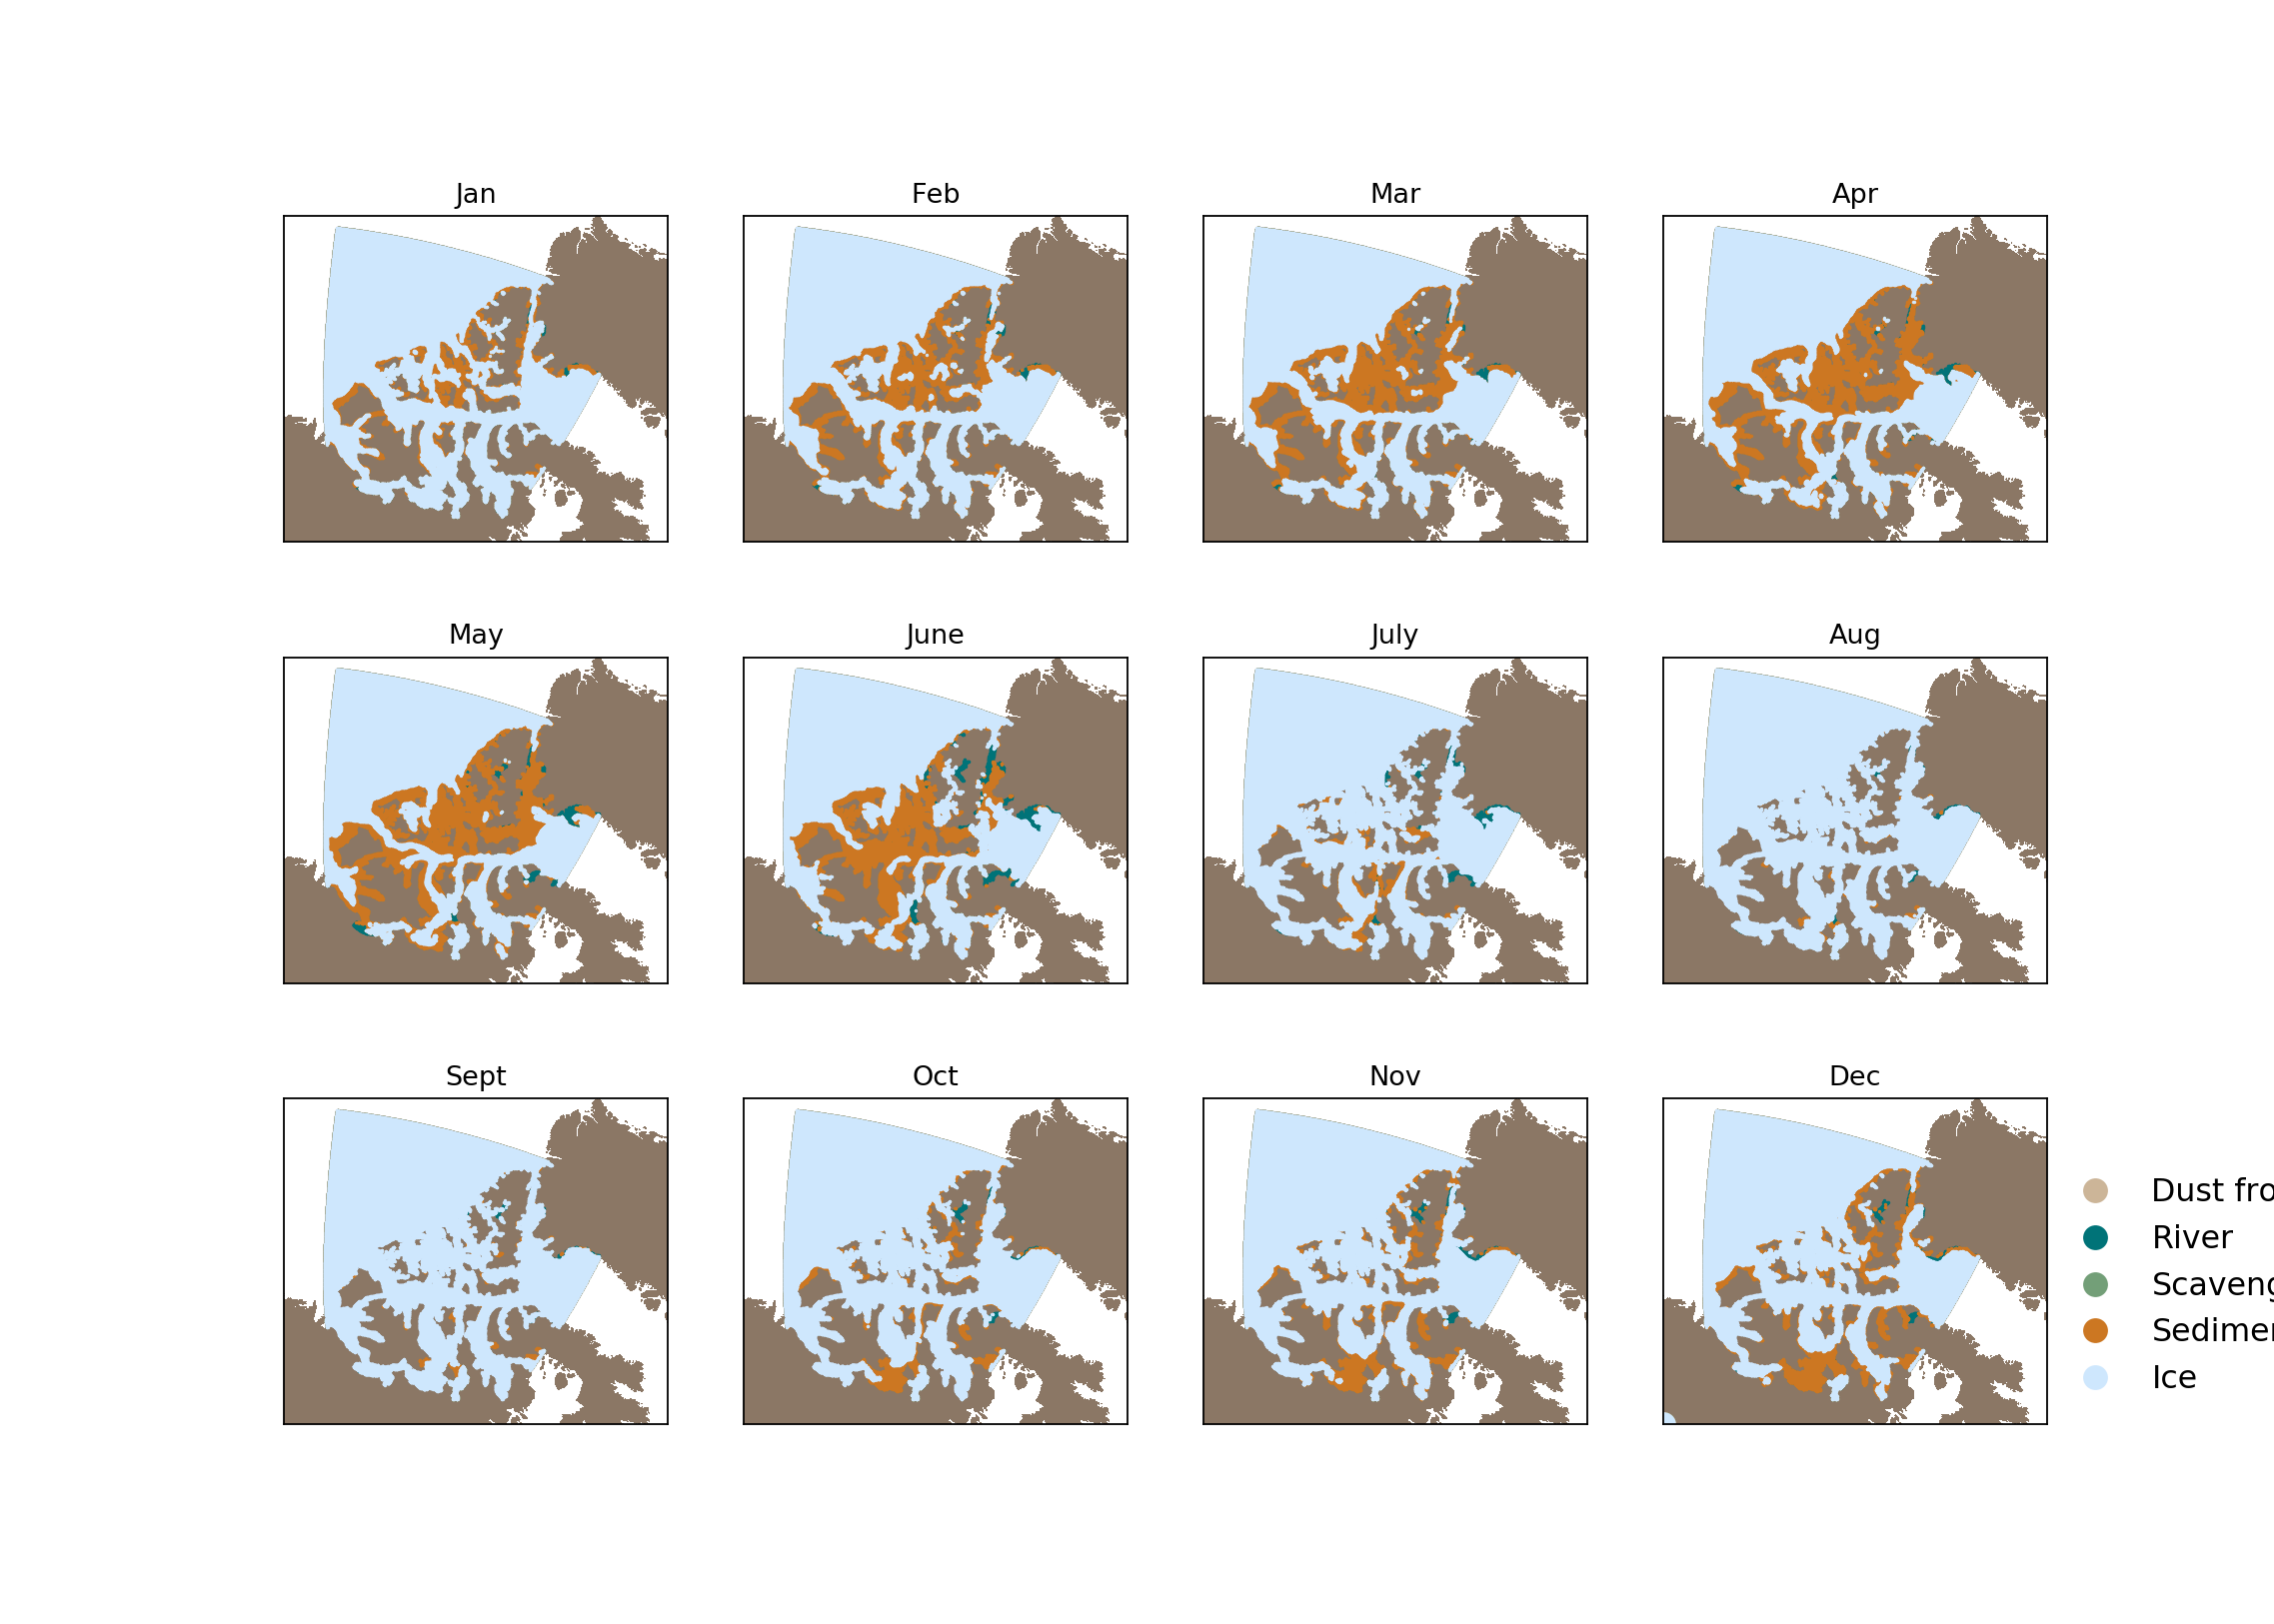

In [40]:
fig, ax, proj1 = pickle.load(open('/ocean/brogalla/GEOTRACES/analysis-brogalla/maps/surface-Mn_subplots.pickle','rb'))

plot_year_importance(z_level, fig, ax, proj1)

proj1.plot(0,0,'.', markersize=20,c=colors[0], label='Dust from atmosphere')
proj1.plot(0,0,'.', markersize=20, c=colors[1], label='River')
proj1.plot(0,0,'.', markersize=20, c=colors[2], label='Scavenging')
proj1.plot(0,0,'.', markersize=20, c=colors[3], label='Sediment')
proj1.plot(0,0,'.', markersize=20, c=colors[4], label='Ice')

ax[2,3].legend(loc=(1.01, 0.05), fontsize=14, frameon=False)

fig.savefig('/ocean/brogalla/GEOTRACES/figures/comp_seasonal.png', bbox_inches='tight')

### If we look at the total impact (i.e. including scavenging removal):

<IPython.core.display.Javascript object>


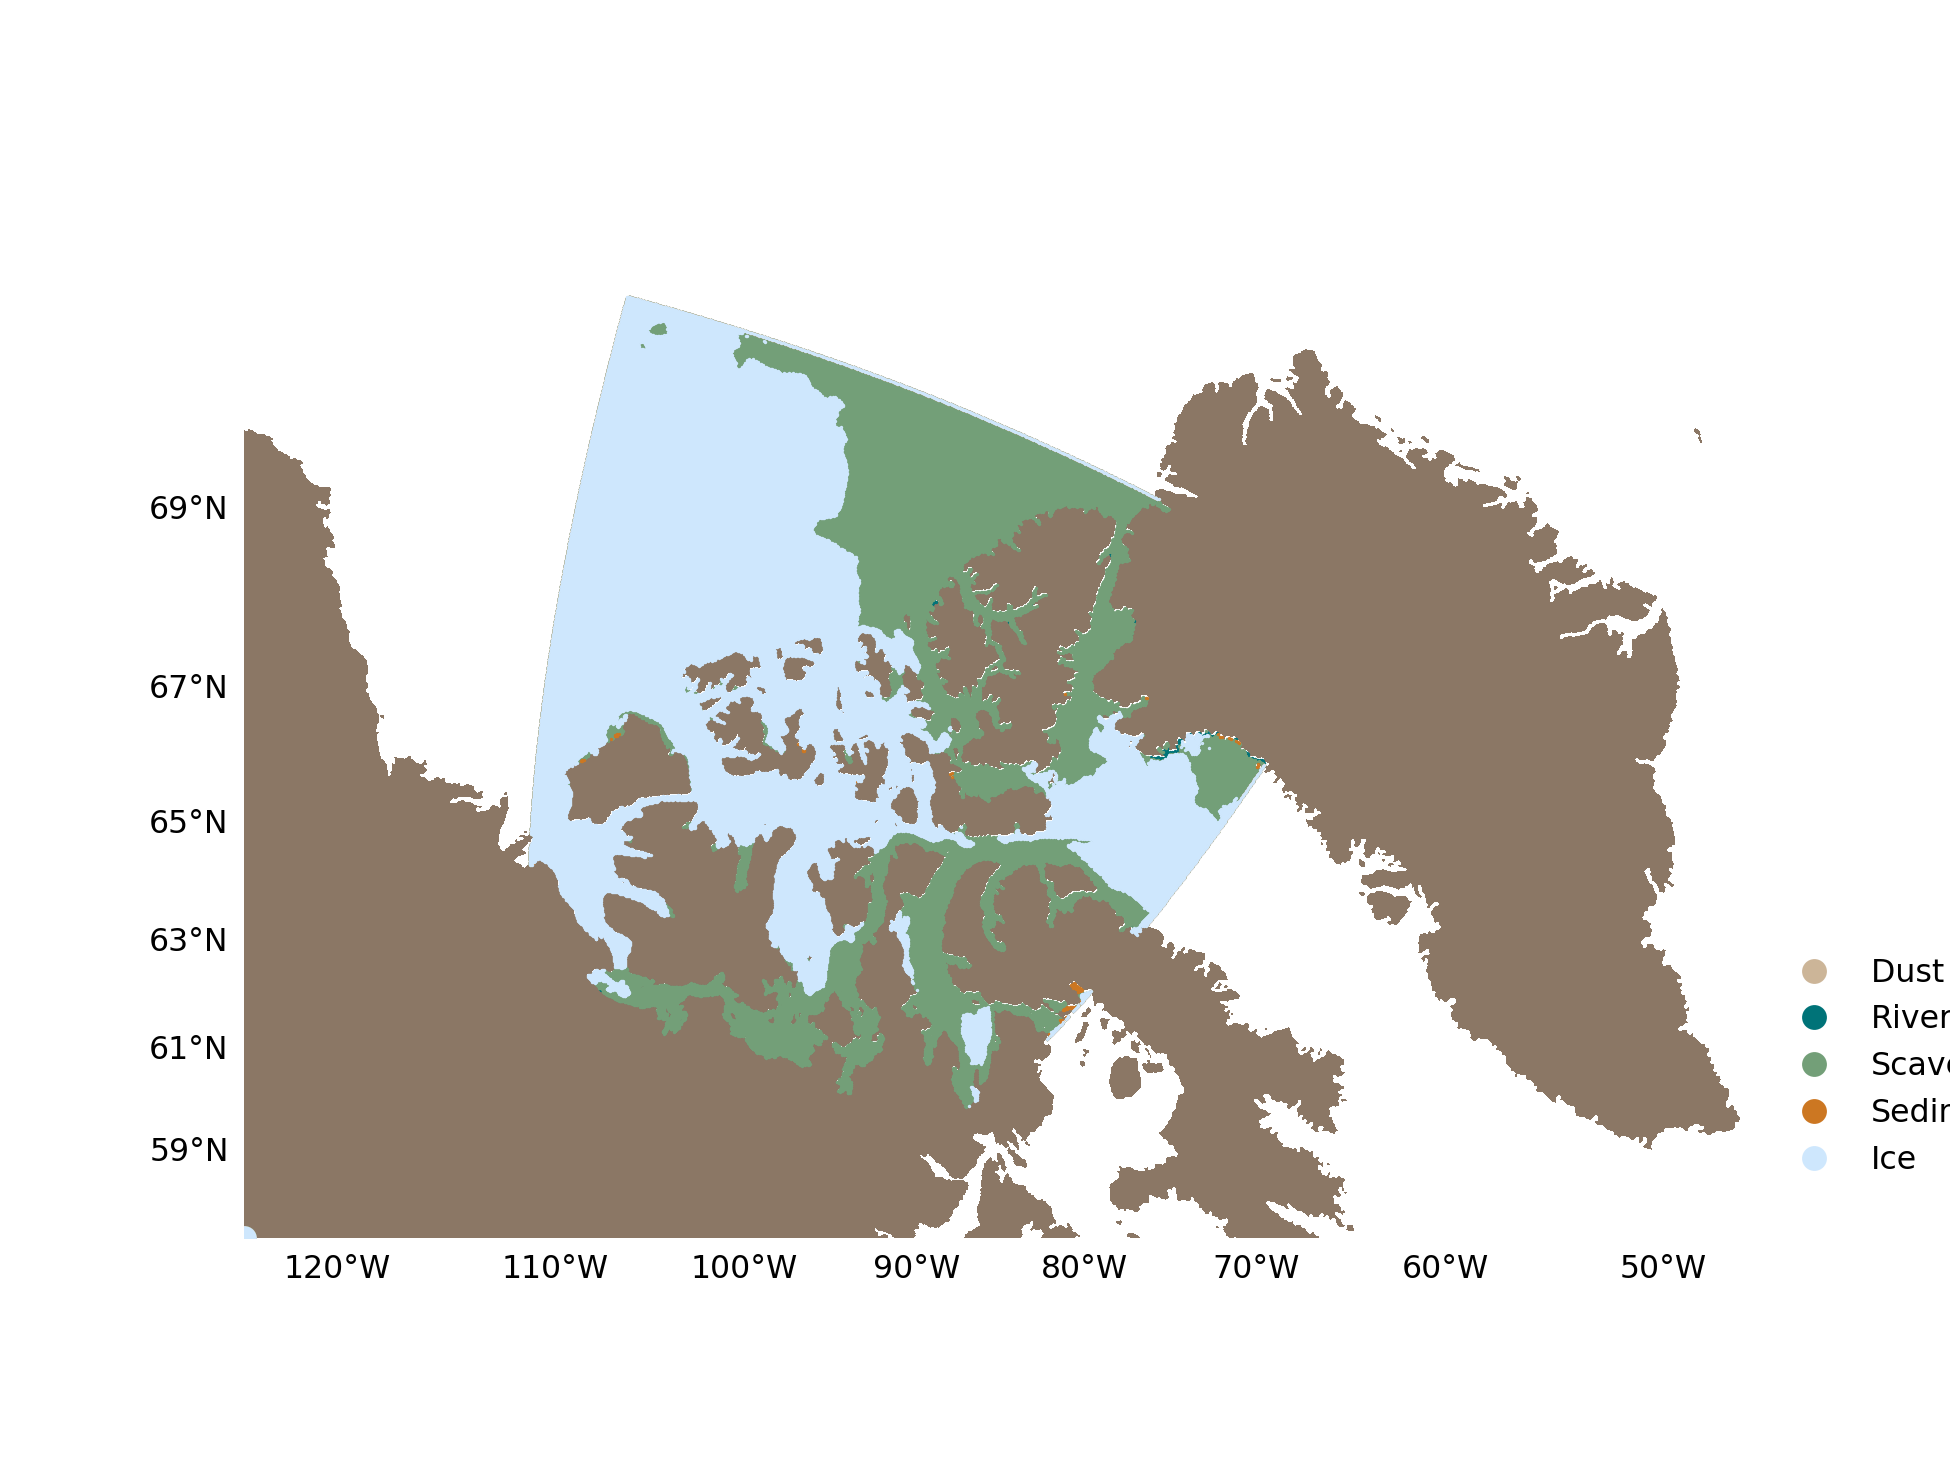

In [17]:
fig, ax1, proj1 = pickle.load(open('/ocean/brogalla/GEOTRACES/analysis-brogalla/maps/mn-reference.pickle','rb'))
#-----------------------------------------------------------------------------
x, y = proj1(lon_model, lat_model)
proj1.plot(x[~atm_imp.mask], y[~atm_imp.mask],'.', markersize=1,c=colors[0])
proj1.plot(x[~riv_imp.mask], y[~riv_imp.mask],'.', markersize=1, c=colors[1])
proj1.plot(x[~sca_imp.mask], y[~sca_imp.mask],'.', markersize=1, c=colors[2])
proj1.plot(x[~sed_imp.mask], y[~sed_imp.mask],'.', markersize=1, c=colors[3])
proj1.plot(x[~ice_imp.mask], y[~ice_imp.mask],'.', markersize=1, c=colors[4])

proj1.plot(0,0,'.', markersize=20,c=colors[0], label='Dust from atmosphere')
proj1.plot(0,0,'.', markersize=20, c=colors[1], label='River')
proj1.plot(0,0,'.', markersize=20, c=colors[2], label='Scavenging')
proj1.plot(0,0,'.', markersize=20, c=colors[3], label='Sediment')
proj1.plot(0,0,'.', markersize=20, c=colors[4], label='Ice')

ax1.legend(loc=(1.01, 0.05), fontsize=14, frameon=False)

# fig.savefig('/ocean/brogalla/GEOTRACES/figures/comp_sources-and-removal.png', bbox_inches='tight')

<IPython.core.display.Javascript object>


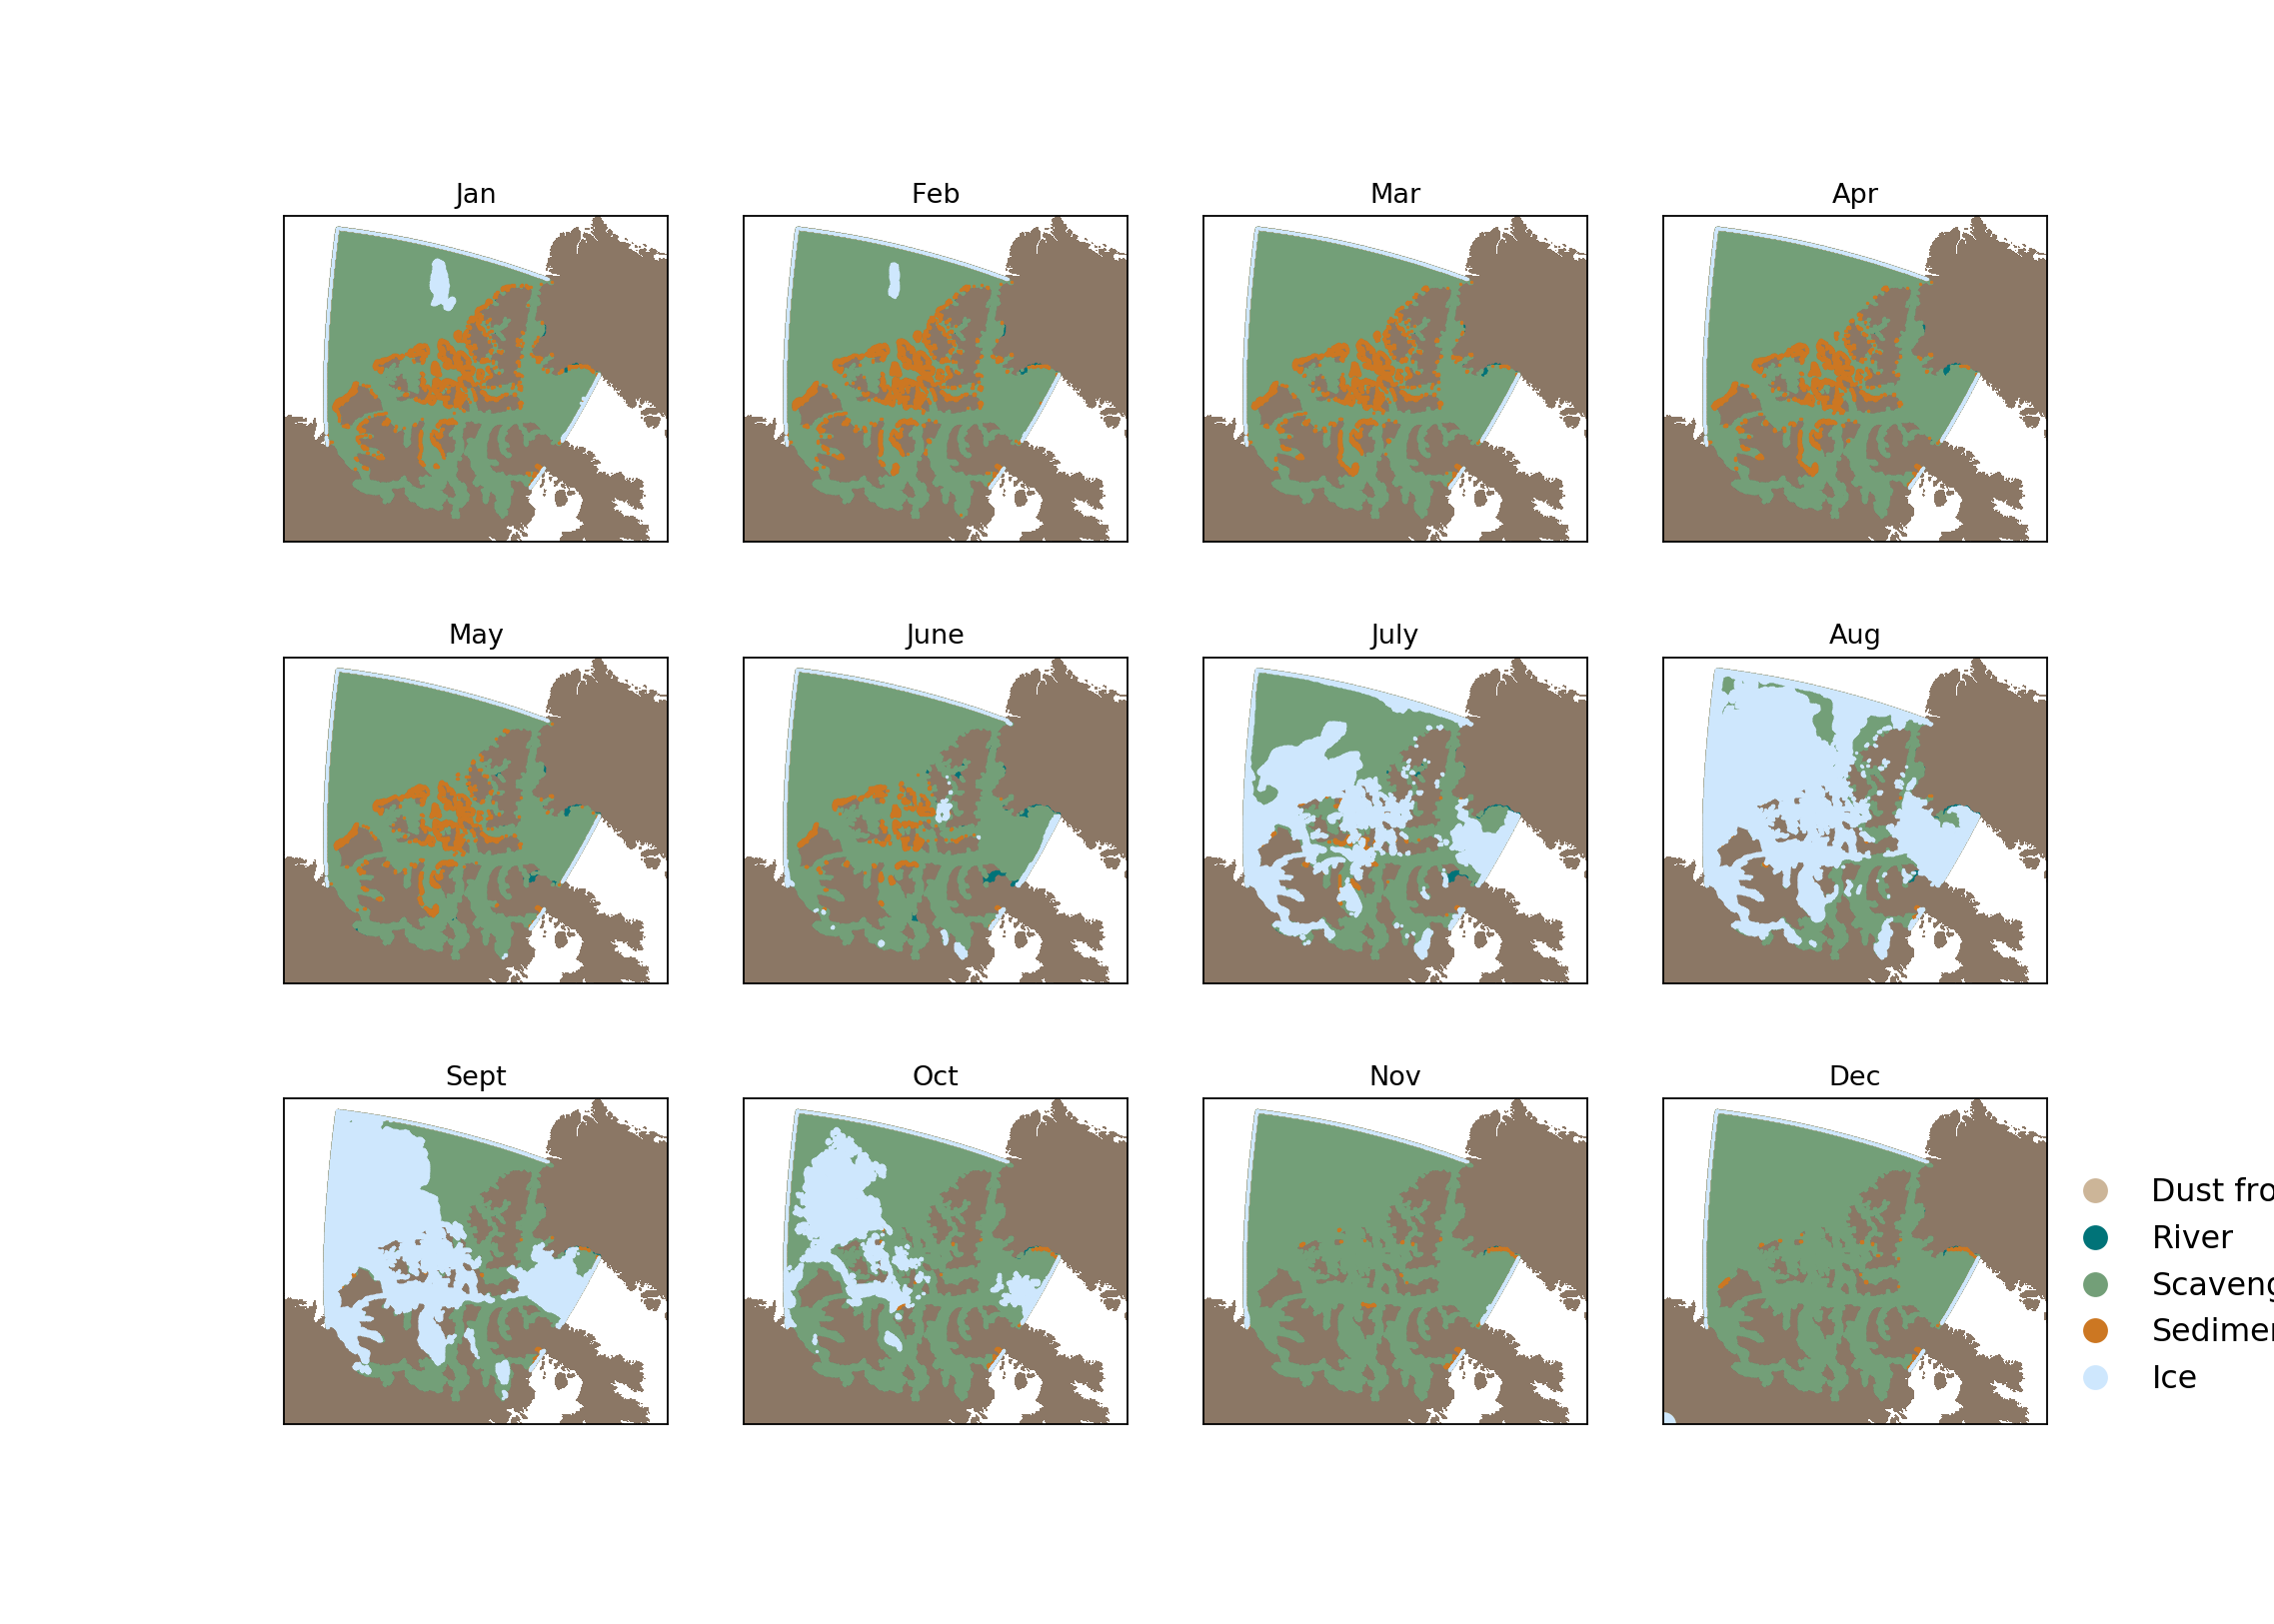

In [21]:
fig, ax, proj1 = pickle.load(open('/ocean/brogalla/GEOTRACES/analysis-brogalla/maps/surface-Mn_subplots.pickle','rb'))

plot_year_importance(z_level, fig, ax, proj1)

proj1.plot(0,0,'.', markersize=20,c=colors[0], label='Dust from atmosphere')
proj1.plot(0,0,'.', markersize=20, c=colors[1], label='River')
proj1.plot(0,0,'.', markersize=20, c=colors[2], label='Scavenging')
proj1.plot(0,0,'.', markersize=20, c=colors[3], label='Sediment')
proj1.plot(0,0,'.', markersize=20, c=colors[4], label='Ice')

ax[2,3].legend(loc=(1.01, 0.05), fontsize=14, frameon=False)

fig.savefig('/ocean/brogalla/GEOTRACES/figures/comp_seasonal-scavenging.png', bbox_inches='tight')

# Same thing but summed over the different water depth layers: